## Fit IGM nuisance parameters to eBOSS P1D, one z at a time

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time, os, sys
import matplotlib.pyplot as plt

# our own modules
from lace.emulator.emulator_manager import set_emulator
from cup1d.p1ds import (
    data_Chabanier2019,
    data_Karacayli2022
)
from cup1d.likelihood import lya_theory, likelihood, emcee_sampler
from cup1d.likelihood.sampler_pipeline import set_archive, set_P1D, set_P1D_hires, set_fid_cosmo, set_like
from cup1d.likelihood.input_pipeline import Args

In [2]:
# set output directory for this test
output_dir = "."

# args = Args(emulator_label="Pedersen21")
args = Args(emulator_label="Pedersen23_ext8")
# args = Args(emulator_label="Cabayol23+", training_set="Cabayol23")
# args = Args(emulator_label="Nyx_alphap", training_set="Nyx23_Oct2023")

args.n_igm=1
args.fix_cosmo=True
#args.n_steps=50
#args.n_burn_in=10
#args.parallel=False
#args.explore=True
args.z_min = 2.3
args.z_max = 3.9
args.data_label = "Chabanier19"
args.data_label_hires = "Karacayli22"
args.add_hires = True
args.add_metals = True

### Set archive

In [3]:
archive = set_archive(args.training_set)

### Set emulator

In [4]:
emulator = set_emulator(
    emulator_label=args.emulator_label,
    archive=archive,
)

Use custom archive provided by the user
Select emulator in Pedersen23_ext8
Gaussian Process emulator predicting the P1D, fitting coefficients to a 5th degree polynomial. It goes to scales of 8 Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Training GP on 330 points


 /global/homes/f/font/.conda/envs/cup1d/lib/python3.11/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 0.22 seconds


### Set fiducial cosmology

In [5]:
cosmo_fid = set_fid_cosmo(cosmo_label=args.cosmo_label)

### Figure out the available redshift bins

We would like to keep a single redshift bin from both the eBOSS P1D and the high-res P1D measurements 

In [6]:
data, true_sim_igm = set_P1D(
    archive,
    emulator,
    args.data_label,
    cosmo_fid,
    cov_label=args.cov_label,
    apply_smoothing=False,
    z_min=args.z_min,
    z_max=args.z_max,
)

extra_data = set_P1D_hires(
    archive,
    emulator,
    cosmo_fid,
    args.data_label_hires,
    args.cov_label_hires,
    apply_smoothing=False,
    z_min=args.z_min,
    z_max=args.z_max,
)

Nz = 14 , Nk = 13


In [7]:
zs=data.z
Nz=len(zs)
print('Nz=',Nz)
print(zs)
print(extra_data.z)

Nz= 8
[2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8]
[2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8]


### Set likelihoods (one per redshift bin)

In [8]:
def get_onez_likelihood(z):
    data, true_sim_igm = set_P1D(
        archive,
        emulator,
        args.data_label,
        cosmo_fid,
        cov_label=args.cov_label,
        apply_smoothing=False,
        z_min=z-0.01,
        z_max=z+0.01,
    )

    extra_data = set_P1D_hires(
        archive,
        emulator,
        cosmo_fid,
        args.data_label_hires,
        args.cov_label_hires,
        apply_smoothing=False,
        z_min=z-0.01,
        z_max=z+0.01,
    )
    
    like = set_like(
        emulator,
        data,
        extra_data,
        true_sim_igm,
        args.igm_label,
        args.n_igm,
        cosmo_fid,
        fix_cosmo=args.fix_cosmo,
        add_metals=args.add_metals,
    )
    
    return like

In [9]:
allz_runs=[]
for iz,z in enumerate(zs):
    like = get_onez_likelihood(z)
    onez_run={'z':z, 'like':like}
    allz_runs.append(onez_run)

Nz = 14 , Nk = 13
Using 1 parameters for IGM model
free parameters ['ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0', 'ln_SiIII_0']
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 14 , Nk = 13
Using 1 parameters for IGM model
free parameters ['ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0', 'ln_SiIII_0']
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 14 , Nk = 13
Using 1 parameters for IGM model
free parameters ['ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0', 'ln_SiIII_0']
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 14 , Nk = 13
Using 1 parameters for IGM model
free parameters ['ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0', 'ln_SiIII_0']
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 14 , Nk = 13
Us

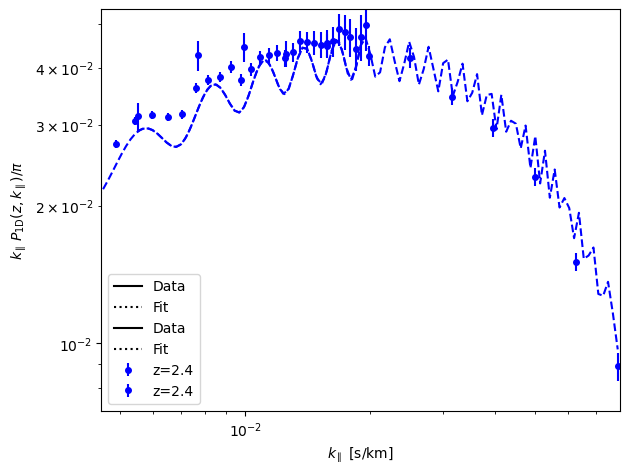

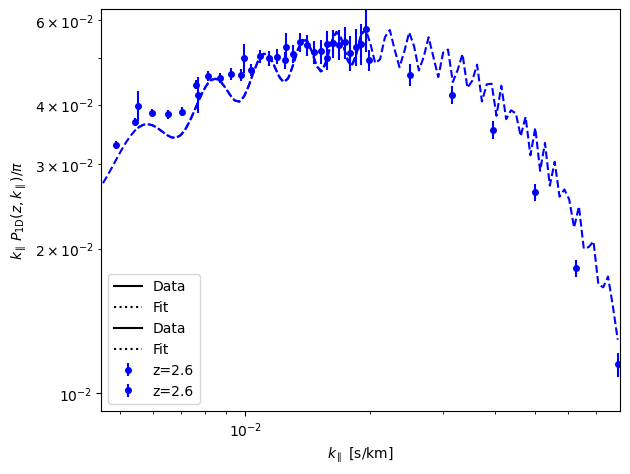

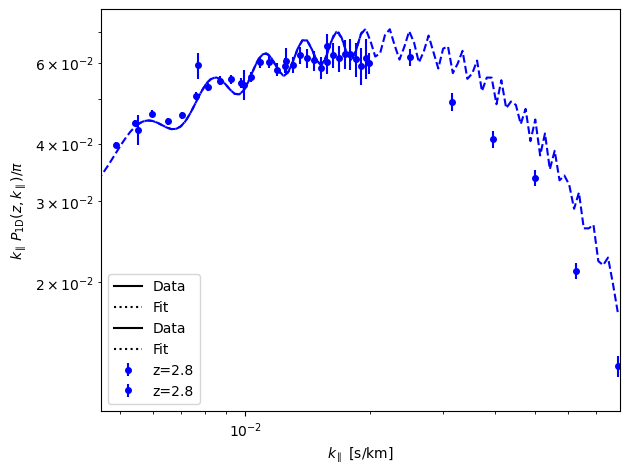

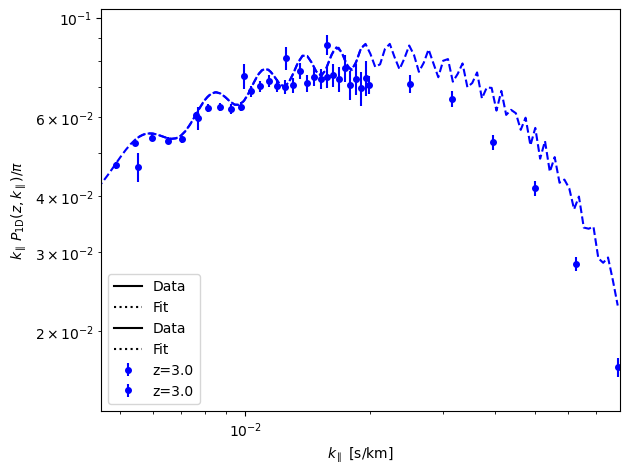

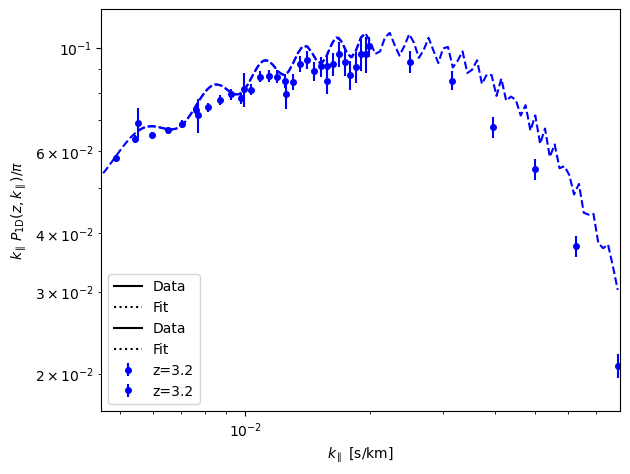

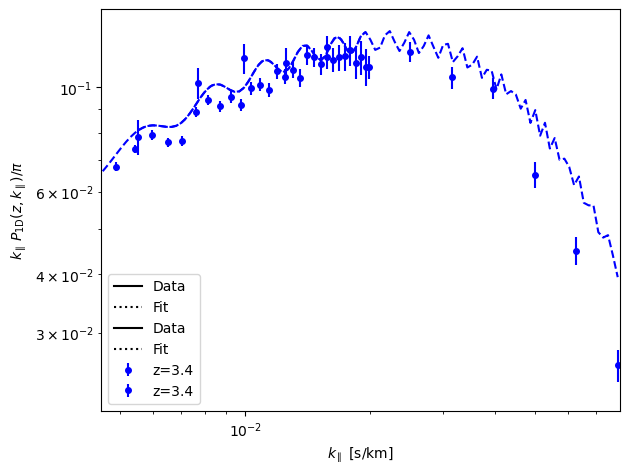

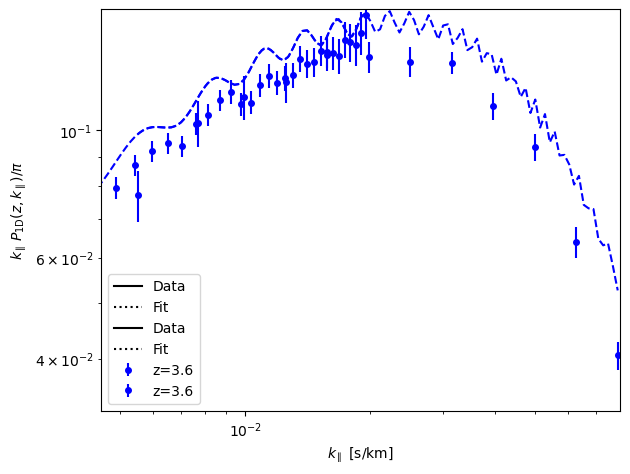

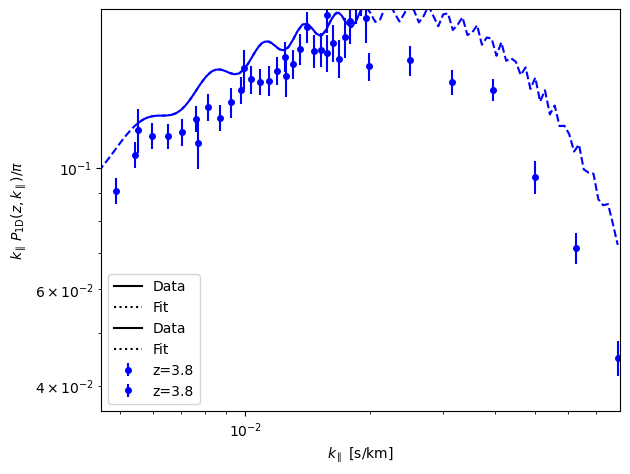

In [10]:
for iz in range(Nz):
    plt.figure()
    allz_runs[iz]['like'].plot_p1d(residuals=False)
    allz_runs[iz]['like'].extra_p1d_like.plot_p1d(residuals=False)
    plt.xscale('log')

In [11]:
def fit_onez_likelihood(like):
    def log_prob(theta):
        return log_prob.sampler.like.log_prob_and_blobs(theta)

    def set_log_prob(sampler):
        log_prob.sampler = sampler
        return log_prob

    sampler = emcee_sampler.EmceeSampler(
        like=like,
        rootdir=output_dir,
        save_chain=False,
        nburnin=args.n_burn_in,
        nsteps=args.n_steps,
        parallel=args.parallel,
        explore=args.explore,
        fix_cosmology=args.fix_cosmo,
    )
    _log_prob = set_log_prob(sampler)
    
#    %%time
#    _emcee_sam = sampler.run_sampler(log_func=_log_prob)

    npar=len(like.free_params)
    sampler.run_minimizer(log_func=_log_prob,p0=0.5*np.ones(npar))
    
    return sampler

In [12]:
for iz in range(Nz):
    sampler = fit_onez_likelihood(allz_runs[iz]['like'])
    allz_runs[iz]['sampler']=sampler

Created directory: ./chain_23
setup with  1  ranks,  201  walkers, and  0  steps
combined steps  0 (should be close to  0 )
Minimization improved: -106.35658390905456 16.48647226311067
MLE: {'$\\mathrm{ln}\\,\\tau_0$': -0.06340902847223484, '$\\mathrm{ln}\\,\\sigma^T_0$': 0.26581953875984166, '$\\mathrm{ln}\\,\\gamma_0$': 0.20052084693690753, '$\\mathrm{ln}\\,k^F_0$': -0.11517123351343361, '$\\mathrm{ln}\\,f^{SiIII}_0$': -5.240107622836918, '$\\Delta^2_\\star$': 0.3466382078507124, '$n_\\star$': -2.297030857431114, '$f_\\star$': -0.21630395006189196, '$g_\\star$': 0.9813418272020591, '$\\alpha_\\star$': 0.9677508029137881, '$H_0$': 67.0}
Created directory: ./chain_24
setup with  1  ranks,  201  walkers, and  0  steps
combined steps  0 (should be close to  0 )
Minimization improved: -123.7147915704859 8.75703323678102
MLE: {'$\\mathrm{ln}\\,\\tau_0$': -0.1408587045941232, '$\\mathrm{ln}\\,\\sigma^T_0$': 0.15304267607848931, '$\\mathrm{ln}\\,\\gamma_0$': 0.20951087660622814, '$\\mathrm{l

Text(0.5, 0.1, 'chi2=28.51, dof=29')

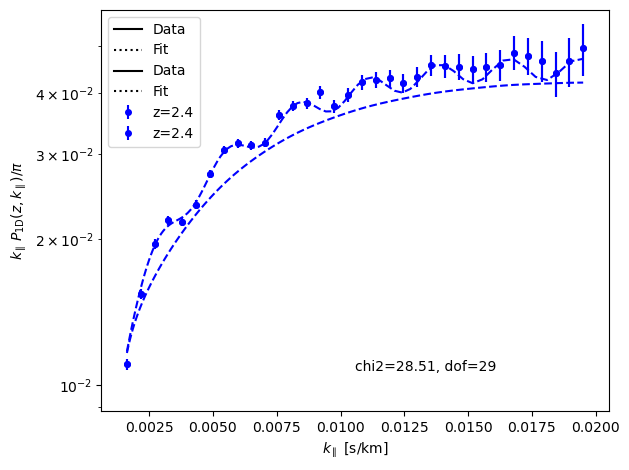

In [13]:
sampler=allz_runs[0]['sampler']
best_fit_values=sampler.mle_cube
npar=len(best_fit_values)
chi2=sampler.like.get_chi2(values=best_fit_values)
dof=len(sampler.like.data.k_kms[0])-npar
f, ax = plt.subplots()
allz_runs[0]['like'].plot_p1d(residuals=False,values=best_fit_values)
allz_runs[0]['like'].plot_p1d(residuals=False,values=0.5*np.ones(5))
plt.text(0.5,0.1,'chi2={:.2f}, dof={}'.format(chi2,dof),transform=ax.transAxes)

In [14]:
len(sampler.like.data.k_kms[0])
sampler.like.get_chi2(values=best_fit_values)

28.512582408717652

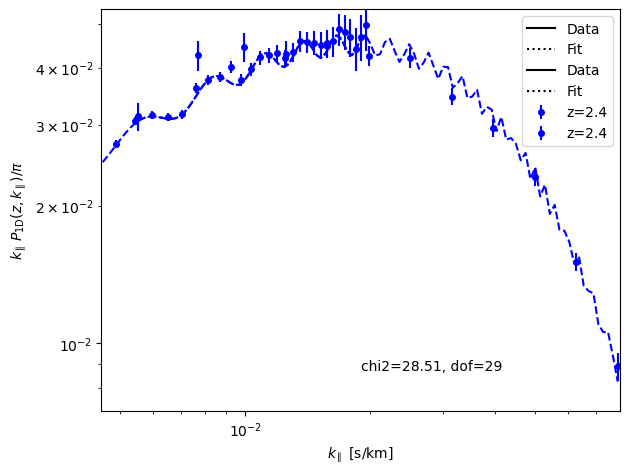

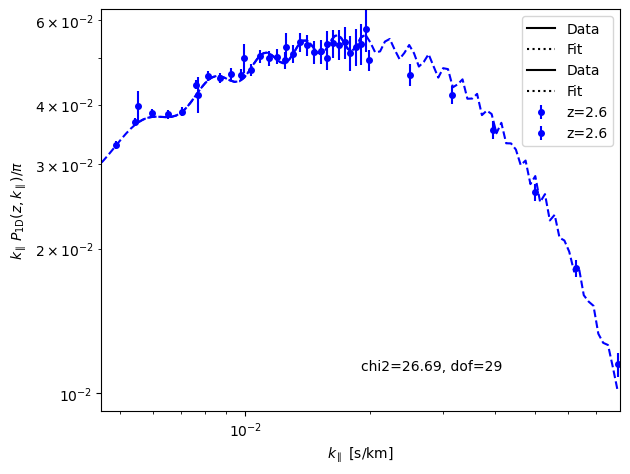

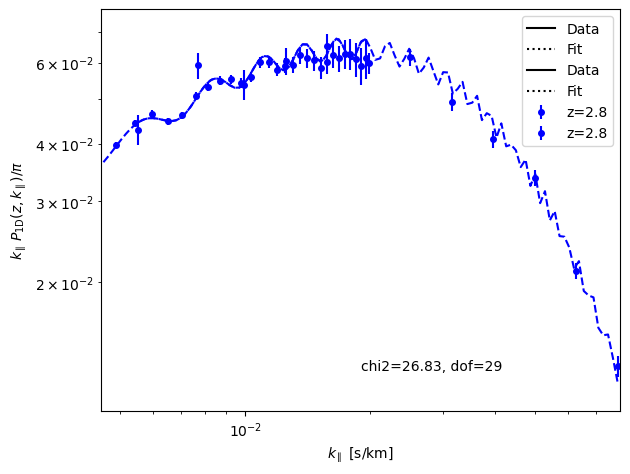

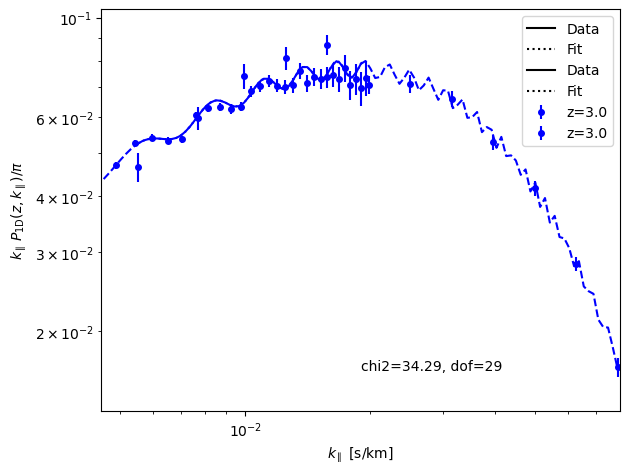

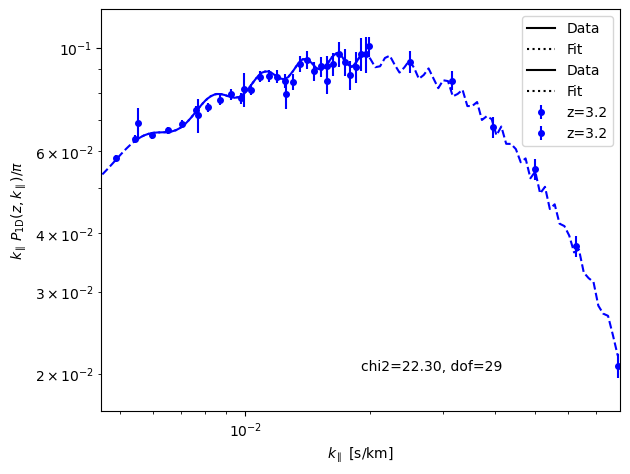

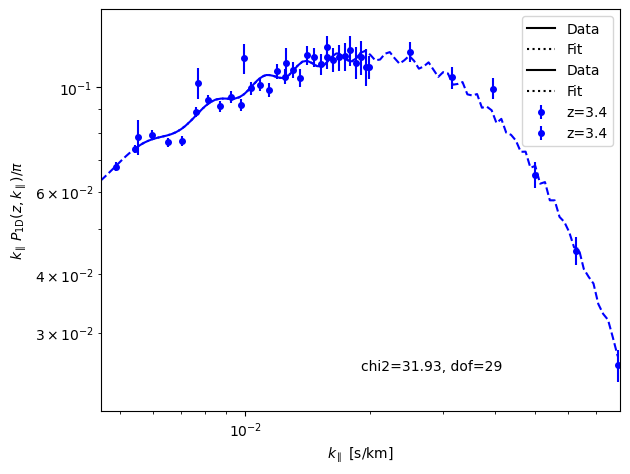

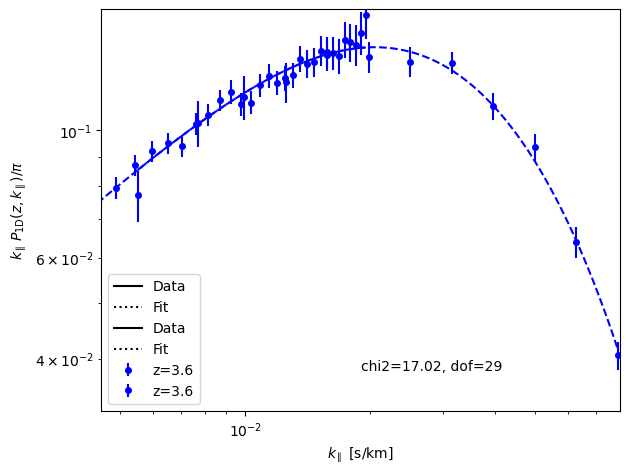

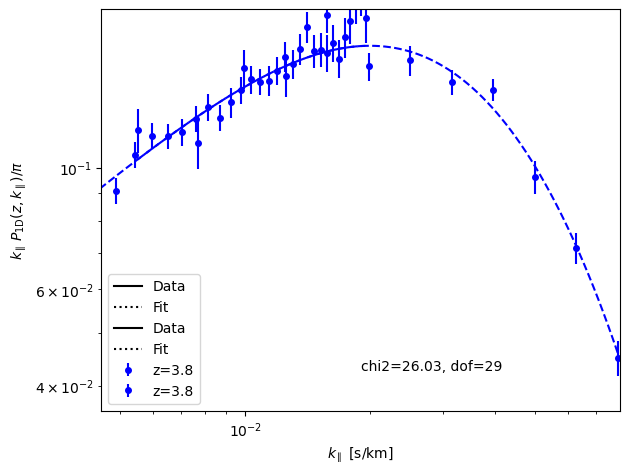

In [15]:
for iz in range(Nz):
    sampler=allz_runs[iz]['sampler']
    
    best_fit_values=sampler.mle_cube
    npar=len(best_fit_values)
    chi2=sampler.like.get_chi2(values=best_fit_values)
    dof=len(sampler.like.data.k_kms[0])-npar
    f, ax = plt.subplots()

    sampler.like.plot_p1d(residuals=False,values=best_fit_values)
#    allz_runs[iz]['like'].plot_p1d(residuals=False,values=0.5*np.ones_like(sampler.mle_cube))
    sampler.like.extra_p1d_like.plot_p1d(residuals=False,values=best_fit_values)
#    allz_runs[iz]['like'].extra_p1d_like.plot_p1d(residuals=False,values=0.5*np.ones_like(sampler.mle_cube))
    plt.xscale('log')
    plt.text(0.5,0.1,'chi2={:.2f}, dof={}'.format(chi2,dof),transform=ax.transAxes)

    plt.savefig('p1d_eboss_highres_z{}.png'.format(zs[iz]))

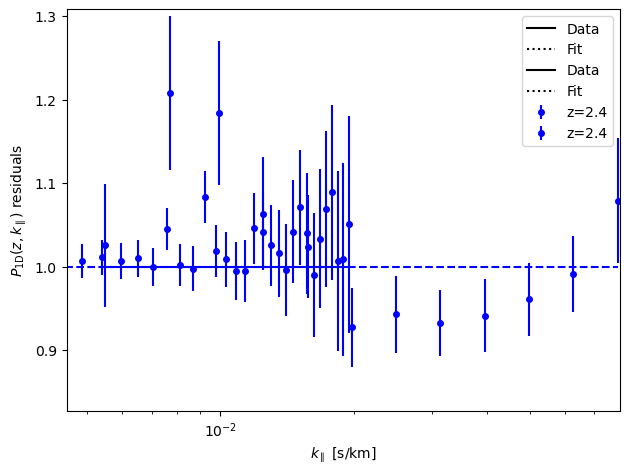

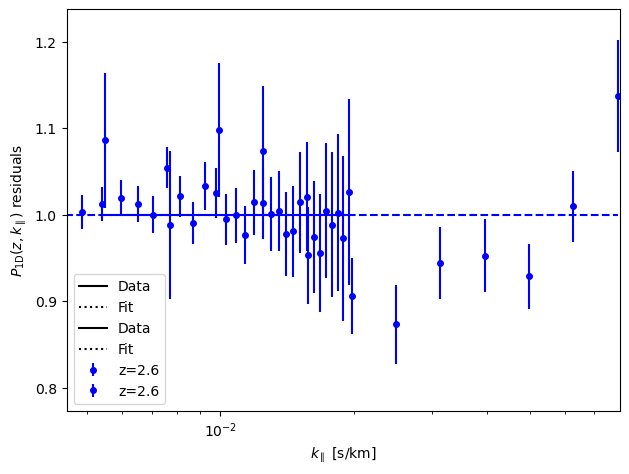

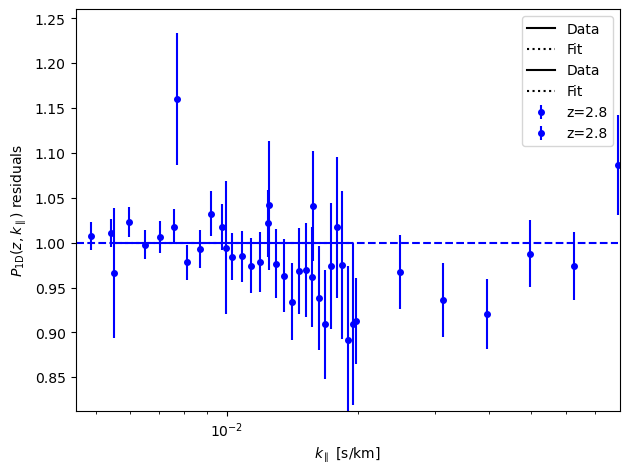

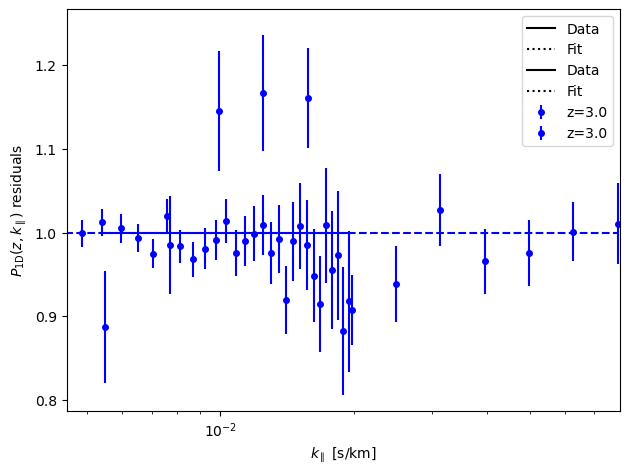

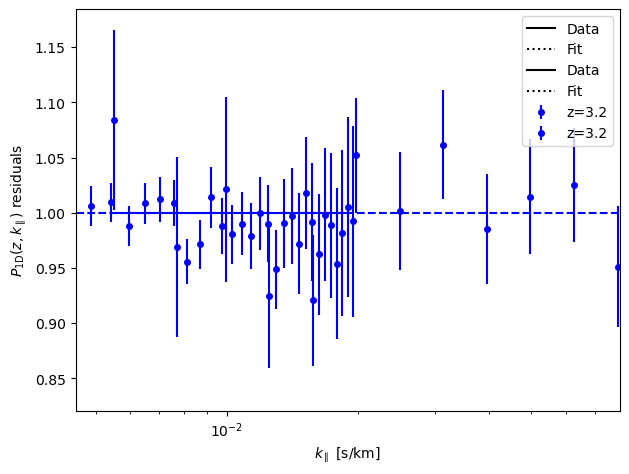

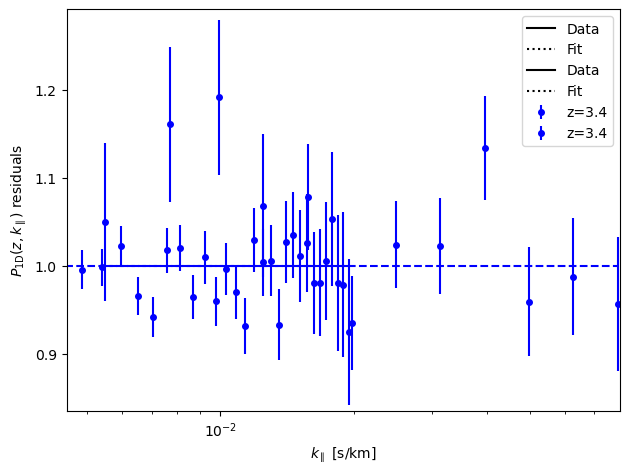

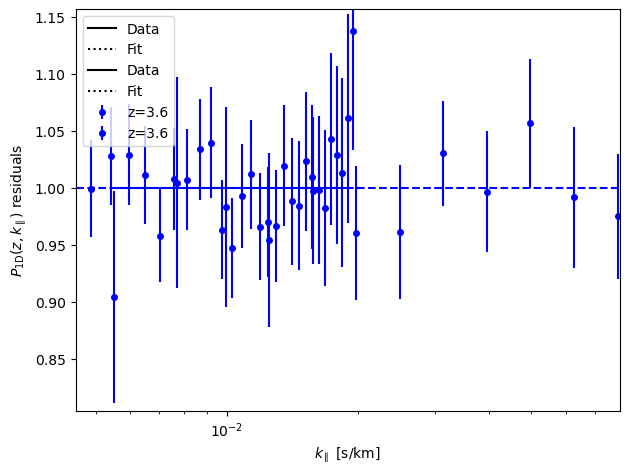

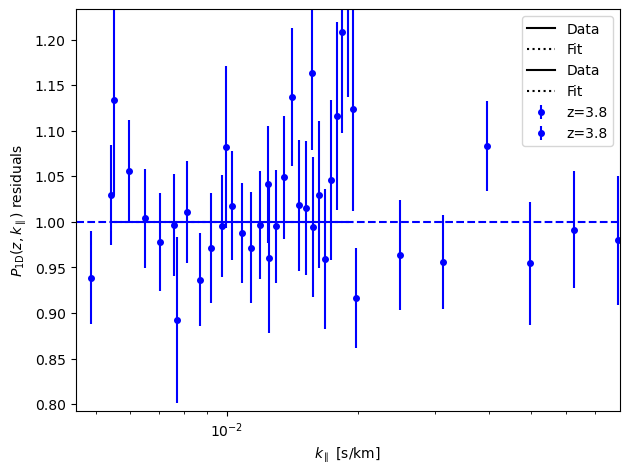

In [16]:
for iz in range(Nz):
    sampler=allz_runs[iz]['sampler']
    plt.figure()
    allz_runs[iz]['like'].plot_p1d(residuals=True,values=sampler.mle_cube)
#    allz_runs[iz]['like'].plot_p1d(residuals=False,values=0.5*np.ones_like(sampler.mle_cube))
    allz_runs[iz]['like'].extra_p1d_like.plot_p1d(residuals=True,values=sampler.mle_cube)
#    allz_runs[iz]['like'].extra_p1d_like.plot_p1d(residuals=False,values=0.5*np.ones_like(sampler.mle_cube))
    plt.xscale('log')
    plt.savefig('res_p1d_eboss_highres_z{}.png'.format(zs[iz]))

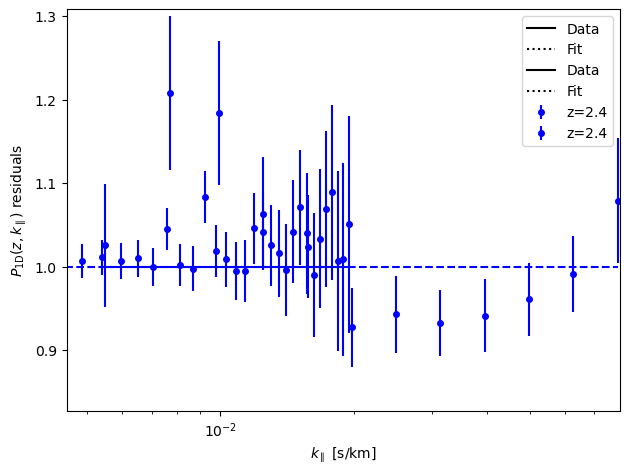

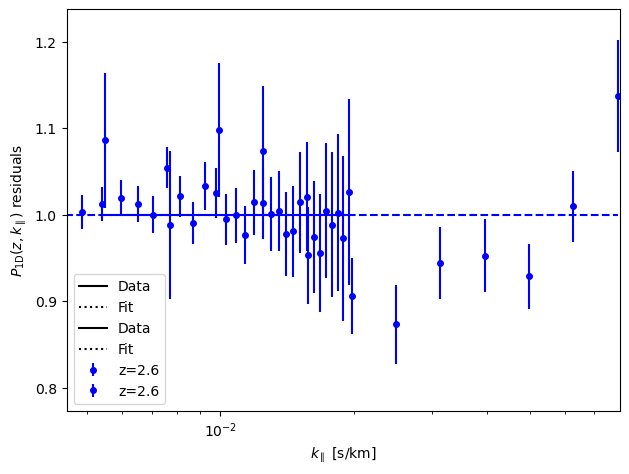

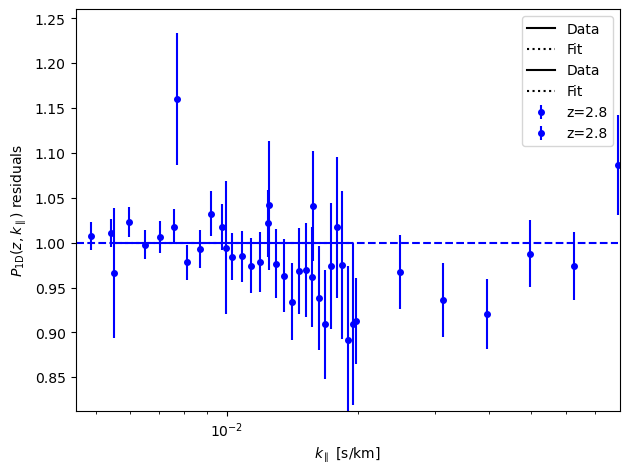

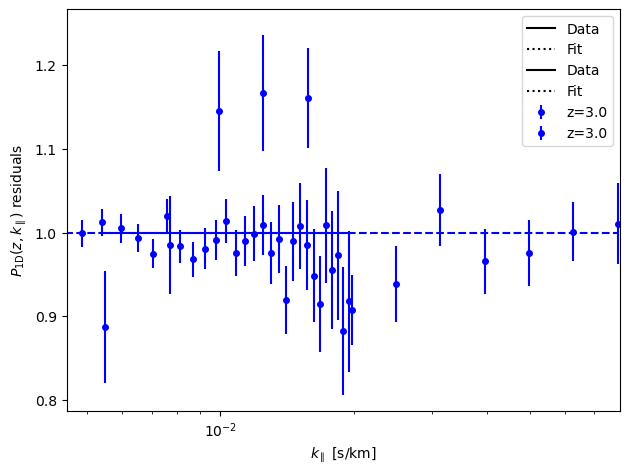

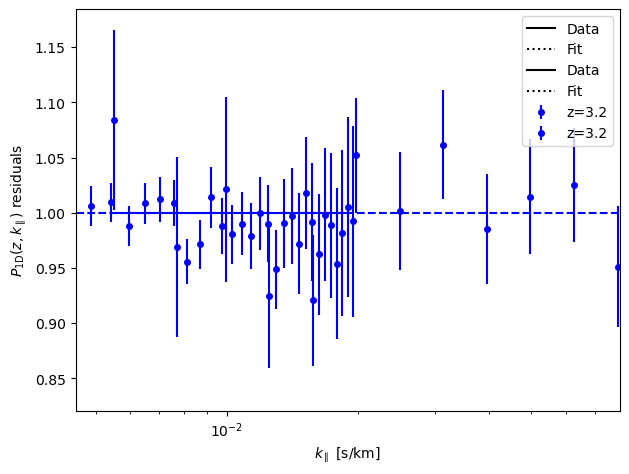

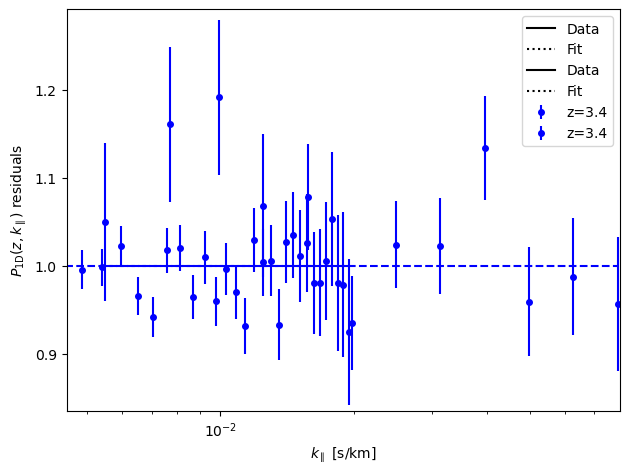

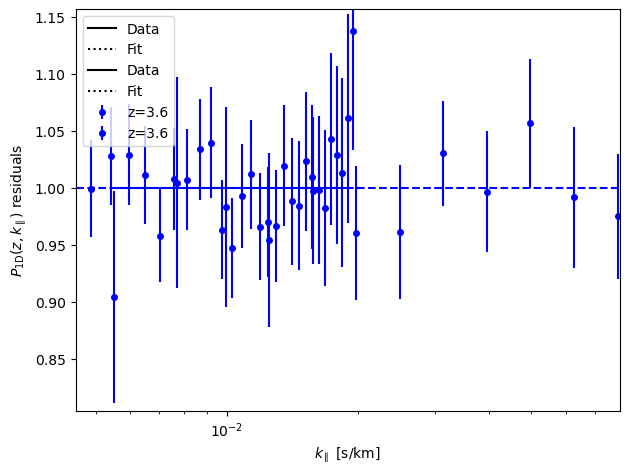

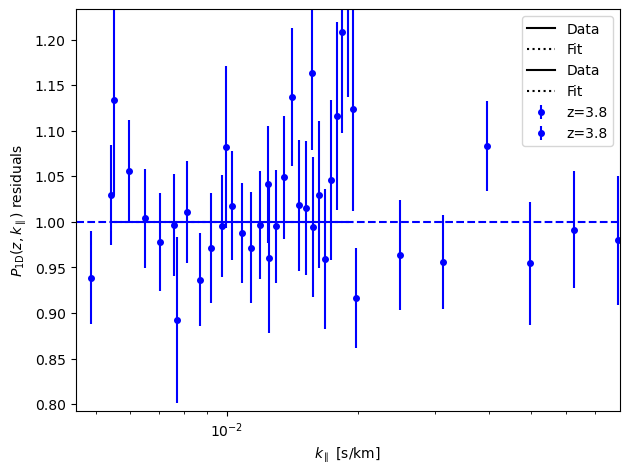

In [17]:
for iz in range(Nz):
    sampler=allz_runs[iz]['sampler']
    plt.figure()
    allz_runs[iz]['like'].plot_p1d(residuals=True,values=sampler.mle_cube)
#    allz_runs[iz]['like'].plot_p1d(residuals=False,values=0.5*np.ones_like(sampler.mle_cube))
    allz_runs[iz]['like'].extra_p1d_like.plot_p1d(residuals=True,values=sampler.mle_cube)
#    allz_runs[iz]['like'].extra_p1d_like.plot_p1d(residuals=False,values=0.5*np.ones_like(sampler.mle_cube))
    plt.xscale('log')
    plt.savefig('res_p1d_eboss_highres_z{}.png'.format(zs[iz]))